In [1]:
import jax
import jax.numpy as np
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy,pickle
from jax.tree_util import tree_map

from jax import jit,vmap
import pandas as pd
import blackjax

import sys,os,importlib,pdb
sys.path.append('/mnt/home/szheng/projects/util_code')
import gm

import scipy
from scipy.signal import find_peaks
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload

import copy

%matplotlib inline
import gm_glm_bayesian as glm

In [2]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']

In [3]:
unit_int = 31
unit_str = f'unit_{unit_int}'

unit_ind_in_pyr = 0

trial_ind_dict = dict(fr.groupby('visitedArm')['trial'].unique())
fr_map_one_unit_both_trials_dict = {k:val[unit_ind_in_pyr] for k,val in fr_map_.items()}
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None)

pars_rand=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


regressors=glm.get_regressors(fr)
target = fr[unit_str].values
pars=gm.init_both_trial_types(fr_map_one_unit_both_trials_dict,trial_ind_dict,bin_to_lin=None,random_init=True)


2022-07-19 10:47:38.831209: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
import sklearn
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

In [24]:
pyr_cols = fr_['cell_cols']['pyr']

In [46]:
spk_count_mat = fr[pyr_cols]


In [172]:
def preprocess(mat,preprocess=['zscore_neuron']):
    mat_p = copy.copy(mat)
    for pp in preprocess:
        if pp=='zscore_neuron':
            mat_p = scipy.stats.zscore(mat_p,axis=0,nan_policy='omit')
            mat_p = mat_p.dropna(axis=1)
        elif pp=='zscore_time':
            mat_p = scipy.stats.zscore(mat_p,axis=1,nan_policy='omit')
            mat_p = mat_p.dropna(axis=0)
            
    
    return mat_p
    

In [119]:
mat_p = preprocess(spk_count_mat, preprocess=['zscore_time'])

pca = PCA(n_components=3)
X = mat_p


X_reduced = pca.fit_transform(X)

In [155]:
def plot_pca3d(toplot,color=None,fig=None,ax=None):
    if ax is None:
        fig=plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
    if color is None:
        color='C0'
    ax.scatter3D(toplot[:,0],toplot[:,1],toplot[:,2],color=color)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    ax.set_zlabel('pc3')
    return fig,ax
    

<IPython.core.display.Javascript object>


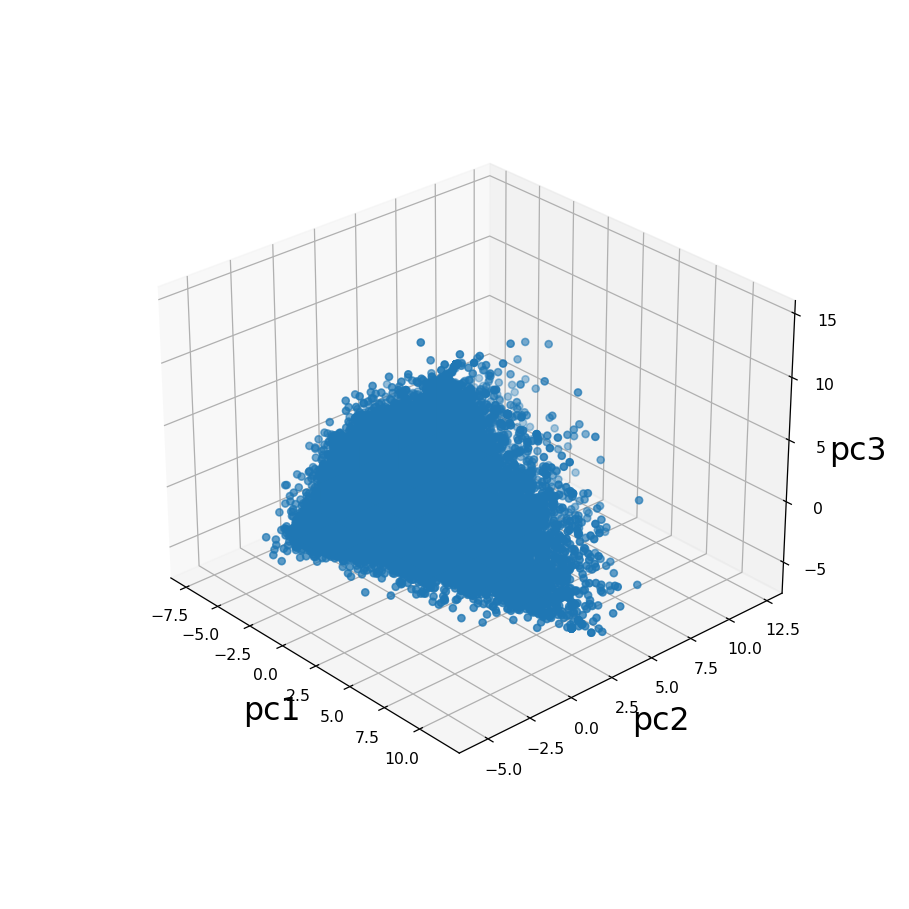

(<Figure size 576x576 with 1 Axes>, <Axes3DSubplot:xlabel='pc1', ylabel='pc2'>)

In [122]:
%matplotlib notebook
plot_pca3d(X_reduced)

<IPython.core.display.Javascript object>


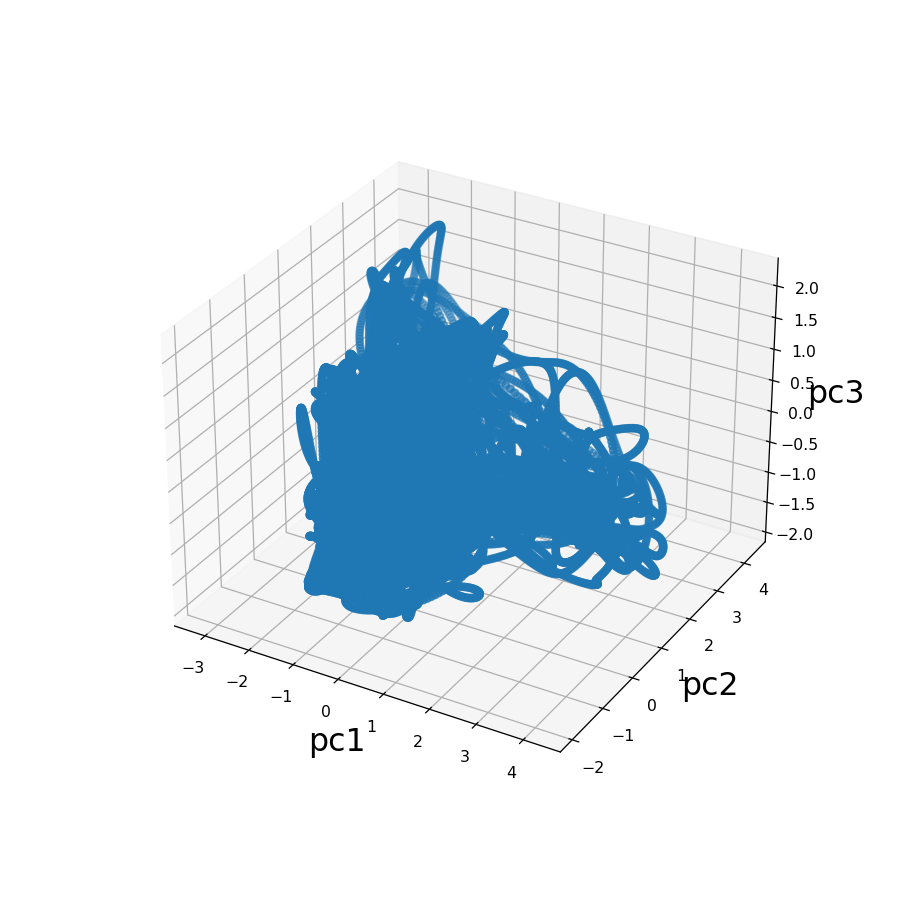

(<Figure size 576x576 with 1 Axes>, <Axes3DSubplot:xlabel='pc1', ylabel='pc2'>)

In [124]:
# guess 1: smooth the resulting pc:
from scipy.ndimage import gaussian_filter1d
X_reduced_smoothed = gaussian_filter1d(X_reduced,sigma=20,axis=0)
plot_pca3d(X_reduced_smoothed)

(<Figure size 576x576 with 1 Axes>, <Axes3DSubplot:xlabel='pc1', ylabel='pc2'>)

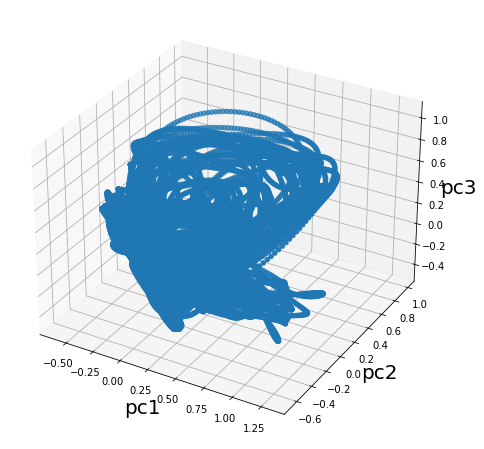

In [140]:
# step 2 smooth the data
mat_p = preprocess(spk_count_mat, preprocess=['zscore_neuron'])
X = spk_count_mat.values.astype(float) #mat_p
X_smoothed = gaussian_filter1d(X,sigma=20,axis=0)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_smoothed)
plot_pca3d(X_reduced)

In [141]:
# step 3: look at data trial by trial

In [161]:
fr.groupby('trial')['visitedArm'].unique()

trial
0.0     [0.0]
1.0     [1.0]
2.0     [0.0]
3.0     [1.0]
4.0     [0.0]
5.0     [1.0]
6.0     [0.0]
7.0     [1.0]
8.0     [1.0]
9.0     [1.0]
10.0    [1.0]
11.0    [0.0]
12.0    [0.0]
13.0    [0.0]
14.0    [1.0]
15.0    [0.0]
16.0    [1.0]
17.0    [0.0]
18.0    [0.0]
19.0    [1.0]
20.0    [0.0]
21.0    [0.0]
22.0    [1.0]
23.0    [0.0]
24.0    [0.0]
25.0    [1.0]
26.0    [0.0]
27.0    [0.0]
28.0    [0.0]
29.0    [0.0]
30.0    [0.0]
31.0    [0.0]
32.0    [1.0]
33.0    [0.0]
34.0    [1.0]
Name: visitedArm, dtype: object

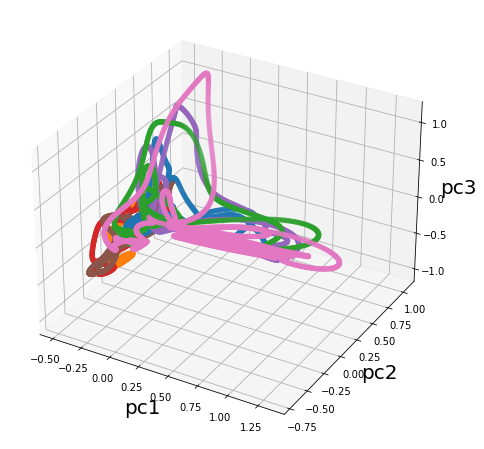

In [178]:
tr=[0,1,2,3,4,5,6]
spk_count_mat = fr.loc[fr['trial'].isin(tr),pyr_cols]
inds_dict={}
color_dict={}
for ii,t in enumerate(tr):
    inds_dict[t]=np.nonzero((fr.loc[fr['trial'].isin(tr),'trial'] == t).values)[0]
    color_dict[t] = f'C{ii}'
mat_p = preprocess(spk_count_mat, preprocess=['zscore_neuron'])
X = spk_count_mat.values.astype(float) #mat_p
X_smoothed = gaussian_filter1d(X,sigma=20,axis=0)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_smoothed)
fig=None
ax=None
for t in tr:
    fig,ax=plot_pca3d(X_reduced[inds_dict[t]],color=color_dict[t],fig=fig,ax=ax)

In [183]:
# now try TSNE

In [184]:
from sklearn.manifold import TSNE

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


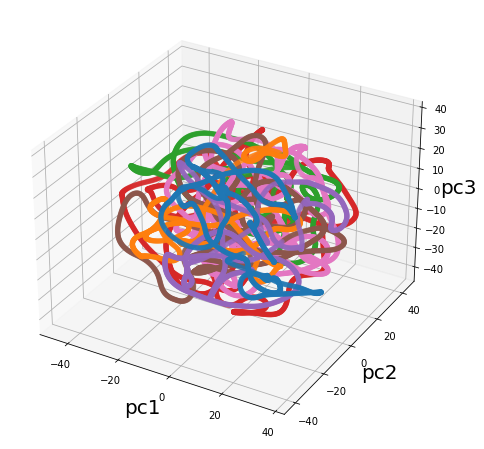

In [186]:
tsne = TSNE(n_components=3,perplexity=5.)

tr=[0,1,2,3,4,5,6]
spk_count_mat = fr.loc[fr['trial'].isin(tr),pyr_cols]
inds_dict={}
color_dict={}
for ii,t in enumerate(tr):
    inds_dict[t]=np.nonzero((fr.loc[fr['trial'].isin(tr),'trial'] == t).values)[0]
    color_dict[t] = f'C{ii}'
mat_p = preprocess(spk_count_mat, preprocess=['zscore_neuron'])
X = spk_count_mat.values.astype(float) #mat_p
X_smoothed = gaussian_filter1d(X,sigma=20,axis=0)

X_reduced = tsne.fit_transform(X_smoothed)

fig=None
ax=None
for t in tr:
    fig,ax=plot_pca3d(X_reduced[inds_dict[t]],color=color_dict[t],fig=fig,ax=ax)